<a href="https://colab.research.google.com/github/kjaron83/tensorflow-tutorials/blob/master/regression/laptop_price/laptop_price_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing the [laptop price](https://www.kaggle.com/ionaskel/laptop-prices) dataset.

In [25]:
# Import required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# Read in the laptop prices dataset
prices = pd.read_csv("https://raw.githubusercontent.com/kjaron83/tensorflow-tutorials/master/regression/laptop_price/laptop_price.csv")
prices

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


In [27]:
# Drop GB from the Ram column
prices["Ram"] = prices["Ram"].str.replace("GB", "")
prices["Ram"] = prices['Ram'].astype(int)
# Drop kg from the Weight column
prices["Weight"] = prices["Weight"].str.replace("kg", "")
prices["Weight"] = prices['Weight'].astype(float)
prices

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.80,638.00
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16,512GB SSD,Intel HD Graphics 520,Windows 10,1.30,1499.00
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2,64GB Flash Storage,Intel HD Graphics,Windows 10,1.50,229.00
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19,764.00


In [28]:
import re

def split_screen_resolution(string):
  """
  Returns the computer screen resolution description as a tuple (screen description, screen_resolution, is_touch).
  E.g.: IPS Panel Quad HD+ / Touchscreen 3200x1800 => ("IPS Panel Quad HD+", "3200x1800", "1")
        Full HD 1920x1080 => ("Full HD", "1920x1080", "0")
  """
  is_touch = re.search(r'Touchscreen', string)
  if is_touch:
    string = string[:is_touch.start()] + string[is_touch.end():]
    is_touch = '1'
  else:
    is_touch = '0'
  
  screen_res = re.search(r'\d{3,4}x\d{3,4}', string)
  if screen_res:
    string = string[:screen_res.start()] + string[screen_res.end():]
    screen_res = screen_res.group(0)
  else:
    screen_res = ''
  
  string = re.sub(r'[^\w\s+]', '', string)
  
  return (string.strip(), screen_res, is_touch)

In [29]:
# Splitting the ScreenResolution column into individual properties
screen = []
resolution = []
touch = []
rows = prices["ScreenResolution"].apply(split_screen_resolution)
for row in rows:
  screen.append(row[0])
  resolution.append(row[1])
  touch.append(row[2])

prices["screen"] = screen
prices["resolution"] = resolution
prices["touch"] = touch

prices = prices.drop("ScreenResolution", axis=1)
prices


,laptop_ID,Company,Product,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,screen,resolution,touch
0,1,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,IPS Panel Retina Display,2560x1600,0
1,2,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,,1440x900,0
2,3,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00,Full HD,1920x1080,0
3,4,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,IPS Panel Retina Display,2880x1800,0
4,5,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,IPS Panel Retina Display,2560x1600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,Intel Core i7 6500U 2.5GHz,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.80,638.00,IPS Panel Full HD,1920x1080,1
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,Intel Core i7 6500U 2.5GHz,16,512GB SSD,Intel HD Graphics 520,Windows 10,1.30,1499.00,IPS Panel Quad HD+,3200x1800,1
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,Intel Celeron Dual Core N3050 1.6GHz,2,64GB Flash Storage,Intel HD Graphics,Windows 10,1.50,229.00,,1366x768,0
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,Intel Core i7 6500U 2.5GHz,6,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19,764.00,,1366x768,0


In [30]:
def calc_memory(amount, measurement):
  """
  Returns the memory size in GBytes.
  """
  return float(amount) * 1024 if measurement == "TB" else float(amount)

def split_memory(s):
  """
  Returns the sizes of the drives (ssd, hdd, flash, hybrid) in GBytes.
  E.g.: 500GB HDD => (0, 500, 0, 0)
        256GB SSD => (256, 0, 0, 0)
        512GB SSD +  1.0TB Hybrid => (512, 0, 0, 1024)

  Returns (nan, nan, nan, nan) if the Memory string cannot not be parsed.
  """
  ssd = 0
  hdd = 0
  flash = 0
  hybrid = 0

  m = re.search("([\d\.]+)(GB|TB) SSD", s)
  if m:
    ssd = calc_memory(m[1], m[2])
    s = s.replace(m[0], "")
  
  m = re.search("([\d\.]+)(GB|TB) HDD", s)
  if m:
    hdd = calc_memory(m[1], m[2])
    s = s.replace(m[0], "")

  m = re.search("([\d\.]+)(GB|TB) Flash Storage", s)
  if m:
    flash = calc_memory(m[1], m[2])
    s = s.replace(m[0], "")

  m = re.search("([\d\.]+)(GB|TB) Hybrid", s)
  if m:
    hybrid = calc_memory(m[1], m[2])
    s = s.replace(m[0], "")

  s = s.replace("+", "")
  if s.strip() != "":
    ssd = float("nan")
    hdd = float("nan")
    flash = float("nan")
    hybrid = float("nan")

  return ssd, hdd, flash, hybrid


In [31]:
# Splitting the Memory column into individual properties
ssd = []
hdd = []
flash = []
hybrid = []
rows = prices["Memory"].apply(split_memory)
for row in rows:
  ssd.append(row[0])
  hdd.append(row[1])
  flash.append(row[2])
  hybrid.append(row[3])

prices["ssd"] = ssd
prices["hdd"] = hdd
prices["flash"] = flash
prices["hybrid"] = hybrid
prices = prices.dropna()

prices = prices.drop("Memory", axis=1)
prices

,laptop_ID,Company,Product,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,screen,resolution,touch,ssd,hdd,flash,hybrid
0,1,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,IPS Panel Retina Display,2560x1600,0,128.0,0.0,0.0,0.0
1,2,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,898.94,,1440x900,0,0.0,0.0,128.0,0.0
2,3,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,575.00,Full HD,1920x1080,0,256.0,0.0,0.0,0.0
3,4,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,2537.45,IPS Panel Retina Display,2880x1800,0,512.0,0.0,0.0,0.0
4,5,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,IPS Panel Retina Display,2560x1600,0,256.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,Intel Core i7 6500U 2.5GHz,4,Intel HD Graphics 520,Windows 10,1.80,638.00,IPS Panel Full HD,1920x1080,1,128.0,0.0,0.0,0.0
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,Intel Core i7 6500U 2.5GHz,16,Intel HD Graphics 520,Windows 10,1.30,1499.00,IPS Panel Quad HD+,3200x1800,1,512.0,0.0,0.0,0.0
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,Intel Celeron Dual Core N3050 1.6GHz,2,Intel HD Graphics,Windows 10,1.50,229.00,,1366x768,0,0.0,0.0,64.0,0.0
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,Intel Core i7 6500U 2.5GHz,6,AMD Radeon R5 M330,Windows 10,2.19,764.00,,1366x768,0,0.0,1024.0,0.0,0.0


In [32]:
# Drop the laptop_ID column
prices = prices.drop("laptop_ID", axis=1)
prices

,Company,Product,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,screen,resolution,touch,ssd,hdd,flash,hybrid
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,IPS Panel Retina Display,2560x1600,0,128.0,0.0,0.0,0.0
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,898.94,,1440x900,0,0.0,0.0,128.0,0.0
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,575.00,Full HD,1920x1080,0,256.0,0.0,0.0,0.0
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,2537.45,IPS Panel Retina Display,2880x1800,0,512.0,0.0,0.0,0.0
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,IPS Panel Retina Display,2560x1600,0,256.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,Intel Core i7 6500U 2.5GHz,4,Intel HD Graphics 520,Windows 10,1.80,638.00,IPS Panel Full HD,1920x1080,1,128.0,0.0,0.0,0.0
1299,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,Intel Core i7 6500U 2.5GHz,16,Intel HD Graphics 520,Windows 10,1.30,1499.00,IPS Panel Quad HD+,3200x1800,1,512.0,0.0,0.0,0.0
1300,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,Intel Celeron Dual Core N3050 1.6GHz,2,Intel HD Graphics,Windows 10,1.50,229.00,,1366x768,0,0.0,0.0,64.0,0.0
1301,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,Intel Core i7 6500U 2.5GHz,6,AMD Radeon R5 M330,Windows 10,2.19,764.00,,1366x768,0,0.0,1024.0,0.0,0.0


In [33]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["Inches", "Ram", "Weight", "touch", "ssd", "hdd", "flash", "hybrid"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["Company", "Product", "TypeName", "Cpu", "Gpu", "OpSys", "screen", "resolution"])
)

# Create X & y
X = prices.drop("Price_euros", axis=1)
y = prices["Price_euros"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

# Notice the normalized/one-hot encoded shape is larger because of the extra columns
X_train_normal.shape, X_train.shape

((1041, 802), (1041, 16))

In [34]:
# Set random seed
tf.random.set_seed(42)

# Create a new model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['mae'])

# Fit the model
history = model.fit(X_train_normal.toarray(), y_train, epochs=100)

Epoch 1/100
33/33 [==============================] - 1s 5ms/step - loss: 640.2363 - mae: 640.2363
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 238.7385 - mae: 238.7385
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 166.2571 - mae: 166.2571
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 130.9692 - mae: 130.9692
Epoch 5/100
33/33 [==============================] - 0s 5ms/step - loss: 120.4717 - mae: 120.4717
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 121.1068 - mae: 121.1068
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 107.3109 - mae: 107.3109
Epoch 8/100
33/33 [==============================] - 0s 5ms/step - loss: 101.0499 - mae: 101.0499
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 102.4068 - mae: 102.4068
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 88.7976 - mae: 88.7976
Epoch 11/100
33/33 [=

In [35]:
# Check the results of the model
model.evaluate(X_test_normal.toarray(), y_test)

9/9 [==============================] - 0s 3ms/step - loss: 145.9717 - mae: 145.9717


[145.97169494628906, 145.97169494628906]

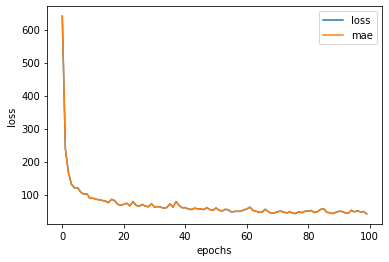

In [36]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");